In [1]:
#!/usr/bin/python

# Import required modules
import os
import sys
sys.path.append('..')

import numpy as np
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mpltkr
import matplotlib.colors as mplcolors
import matplotlib.patches as mplpatches
import matplotlib.lines as mpllines
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Utilities
import project_utils as utils
import h5py

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
color_list = cosmostyle.color_cycle

# PCA on structures

In [2]:
deem_dir = '../../Processed_Data/DEEM_330k'
iza_dir = '../../Processed_Data/IZA_230'
data_dir = 'Data/6.0/Linear_Models/PCA'

In [3]:
cantons = np.loadtxt('../../Raw_Data/IZA_230/cantons.dat', usecols=1, dtype=int)
n_iza = len(cantons)

iza_delete = np.nonzero(cantons == 4)[0]
deem_delete = np.loadtxt('../../Processed_Data/DEEM_330k/10kJmol_error.idxs', dtype=int)

In [4]:
# Load Deem 10k PCA
deem_pca = utils.load_hdf5(f'{deem_dir}/{data_dir}/pca_structures.hdf5')
deem_pca = np.delete(deem_pca, deem_delete, axis=0)

# Load IZA PCA
iza_pca = utils.load_hdf5(f'{iza_dir}/{data_dir}/pca_structures.hdf5')

In [8]:
# Structure energies
deem_330k_energies = np.loadtxt('../../Processed_Data/DEEM_330k/Data/structure_energies.dat')
deem_330k_energies = np.delete(deem_330k_energies, deem_delete)

iza_energies = np.loadtxt('../../Processed_Data/IZA_230/Data/structure_energies.dat')
#iza_energies = np.delete(iza_energies, iza_delete)

energies = np.concatenate((iza_energies, deem_330k_energies))

In [9]:
# Structure volumes
deem_330k_volumes = np.loadtxt('../../Processed_Data/DEEM_330k/Data/structure_volumes.dat')
deem_330k_volumes = np.delete(deem_330k_volumes, deem_delete)

iza_volumes = np.loadtxt('../../Processed_Data/IZA_230/Data/structure_volumes.dat')
#iza_volumes = np.delete(iza_energies, iza_delete)

volumes = np.concatenate((iza_volumes, deem_330k_volumes))

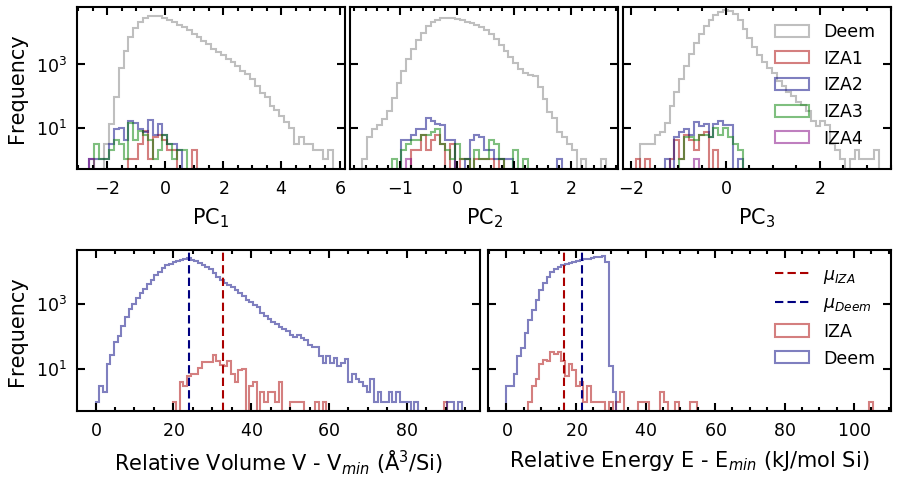

In [10]:
# Histogram of PCA values

# PCA HISTOGRAM
n_pca = 3
fig = plt.figure(figsize=(7.0, 3.5))
gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0.50)

pca_gs = gs[0].subgridspec(1, n_pca, wspace=0.02)
pca_axes = [fig.add_subplot(pca_gs[i]) for i in range(0, n_pca)]
pca_grouper = pca_axes[0].get_shared_y_axes()
for ax in pca_axes[1:]:
    pca_grouper.join(ax, pca_axes[0])
    ax.tick_params(labelleft=False)

hist_gs = gs[1].subgridspec(1, 2, wspace=0.02)
axs_volume = fig.add_subplot(hist_gs[0])
axs_energy = fig.add_subplot(hist_gs[1])
hist_grouper = axs_energy.get_shared_y_axes()
hist_grouper.join(axs_energy, axs_volume)
axs_energy.tick_params(labelleft=False)

histogram_max = np.amax(np.vstack((iza_pca, deem_pca)), axis=0)
histogram_min = np.amin(np.vstack((iza_pca, deem_pca)), axis=0)
#histogram_parameters = dict(bins=50, density=True, log=False, alpha=0.5)
histogram_parameters = dict(bins=50, density=False, log=True, alpha=0.5)

h_max = 0.0
for pc, axs in enumerate(pca_axes):
    histogram_range = (histogram_min[pc], histogram_max[pc])  
    
#     h_deem, bins_deem = kde(
#         deem_pca[:, pc], 
#         range=histogram_range, bins=histogram_parameters['bins'] #, weights=deem_weights
#     )
#     axs.semilogy(bins_deem, h_deem, color=color_list[5], label='Deem')
    h_deem, bins_deem, _ = axs.hist(
        deem_pca[:, pc], range=histogram_range, 
        #weights=deem_weights,
        **histogram_parameters, color=color_list[5], histtype='step', label='Deem'
    )
    
    for i in range(1, np.amax(cantons)+1):
        canton_idxs = np.nonzero(cantons == i)[0]
        
#         if i < 4:
#             h_iza, bins_iza = kde(
#                 iza_pca[canton_idxs, pc], 
#                 range=histogram_range, bins=histogram_parameters['bins'] #, weights=iza_weights_4[canton_idxs]
#             )
#             print(h_iza)
#             print(bins_iza)
#             print(iza_pca[canton_idxs, pc])
#             axs.semilogy(bins_iza, h_iza, color=color_list[i], label=f'IZA{i}')
#         else:
#             axs.scatter(iza_pca[canton_idxs, pc], 0.0, marker='o', color=color_list[i])
        h_iza, bins_iza, _ = axs.hist(
            iza_pca[canton_idxs, pc], range=histogram_range, 
            #weights=iza_weights_4[canton_idxs], 
            **histogram_parameters, color=color_list[i], histtype='step', label=f'IZA{i}'
        )
        
        if i < 4:
            h_max = np.maximum(h_max, np.amax(np.concatenate((h_deem, h_iza))))
      
    #axs.ticklabel_format(axis='both', style='scientific', scilimits=(0, 0), useMathText=True)
    axs.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0), useMathText=True)
    
    if pc == 0:
        #axs.set_ylabel('Prob. Density')
        axs.set_ylabel('Frequency')
    else:
        offset_txt = axs.get_yaxis().get_offset_text().set_visible(False)
        
    axs.set_xlabel(fr'PC$_{{{pc+1}}}$')
    axs.set_ylim((0.5, axs.get_ylim()[1]))

pca_axes[-1].legend()

# yscale = 0.10
# for axs in pca_axes:
#     axs.set_ylim([0.0, h_max+yscale*h_max])

# VOLUME HISTOGRAM
volume_histogram_parameters = dict(
    #range=(np.amin(energies), np.amax(energies)), 
    range=(0.0, np.amax(volumes)-np.amin(volumes)), 
    #density=True, bins=100, log=False, alpha=0.5
    density=False, bins=100, log=True, alpha=0.5
)

# h_vol_iza, vol_bins_iza = kde(
#     volumes[0:n_iza]-np.amin(volumes), 
#     range=volume_histogram_parameters['range'], bins=volume_histogram_parameters['bins'] #, weights=iza_weights
# )
# axs_volume.semilogy(vol_bins_iza, h_vol_iza, color=color_list[1], label='IZA')
axs_volume.hist(
    volumes[0:n_iza]-np.amin(volumes), #weights=iza_weights,
    **volume_histogram_parameters, color=color_list[1], histtype='step', label='IZA'
)
axs_volume.axvline(
    np.mean(volumes[0:n_iza]-np.amin(volumes)), 
    color=color_list[1], linestyle='--', label=r'$\mu_{IZA}$'
)

# h_vol_deem, vol_bins_deem = kde(
#     volumes[n_iza:]-np.amin(volumes), 
#     range=volume_histogram_parameters['range'], bins=volume_histogram_parameters['bins'] #, weights=iza_weights
# )
# axs_volume.semilogy(vol_bins_deem, h_vol_deem, color=color_list[2], label='Deem')
axs_volume.hist(
    volumes[n_iza:]-np.amin(volumes), #weights=deem_weights,
    **volume_histogram_parameters, color=color_list[2], histtype='step', label='Deem'
)
axs_volume.axvline(
    np.mean(volumes[n_iza:]-np.amin(volumes)), 
    color=color_list[2], linestyle='--', label=r'$\mu_{Deem}$'
)

#axs_volume.set_ylabel('Prob. Density')
axs_volume.set_ylabel('Frequency')
axs_volume.set_xlabel(r'Relative Volume V - V$_{min}$ ' + u'(\u00c5' + r'$^3$/Si)')
axs_volume.ticklabel_format(axis='x', style='plain', scilimits=(0, 0), useMathText=True)
axs_volume.set_ylim((0.5, axs_volume.get_ylim()[1]))

#axs_volume.legend(fontsize='large')

# ENERGY HISTOGRAM
energy_histogram_parameters = dict(
    #range=(np.amin(energies), np.amax(energies)), 
    range=(0.0, np.amax(energies)-np.amin(energies)), 
    #density=True, bins=100, log=False, alpha=0.5
    density=False, bins=100, log=True, alpha=0.5
)

# h_energy_iza, bins_energy_iza = kde(
#     energies[0:n_iza]-np.amin(energies), 
#     range=energy_histogram_parameters['range'], bins=energy_histogram_parameters['bins'] #, weights=iza_weights
# )
# axs_energy.semilogy(bins_energy_iza, h_energy_iza, color=color_list[1], label='IZA')
axs_energy.hist(
    energies[0:n_iza]-np.amin(energies), #weights=iza_weights,
    **energy_histogram_parameters, color=color_list[1], histtype='step', label='IZA'
)
axs_energy.axvline(
    np.mean(energies[0:n_iza]-np.amin(energies)), 
    color=color_list[1], linestyle='--', label=r'$\mu_{IZA}$'
)

# h_energy_deem, bins_energy_deem = kde(
#     energies[n_iza:]-np.amin(energies), 
#     range=energy_histogram_parameters['range'], bins=energy_histogram_parameters['bins'] #, weights=deem_weights
# )
# axs_energy.semilogy(bins_energy_deem, h_energy_deem, color=color_list[2], label='Deem')
axs_energy.hist(
    energies[n_iza:]-np.amin(energies), #weights=deem_weights,
    **energy_histogram_parameters, color=color_list[2], histtype='step', label='Deem'
)
axs_energy.axvline(
    np.mean(energies[n_iza:]-np.amin(energies)), 
    color=color_list[2], linestyle='--', label=r'$\mu_{Deem}$'
)

axs_energy.set_xlabel(r'Relative Energy E - E$_{min}$ (kJ/mol Si)')
axs_energy.ticklabel_format(axis='x', style='plain', scilimits=(0, 0), useMathText=True)
axs_energy.set_ylim((0.5, axs_energy.get_ylim()[1]))

axs_energy.legend()

fig.align_ylabels()

fig.savefig('../../Results/6.0/pca_histogram_6.0.pdf', bbox_inches='tight')

plt.show()

In [11]:
# Camera view settings
x = -1.25
y = -1.25
z = 0.50

# Compute aspect ratio from data
# so we can set it manually including zoom
zoom = 2.4
aspect_ratio_keys = ['x', 'y', 'z']
xyz_max = np.amax(np.vstack((deem_pca[:, 0:3], iza_pca[:, 0:3])), axis=0)
xyz_min = np.amin(np.vstack((deem_pca[:, 0:3], iza_pca[:, 0:3])), axis=0)
xyz_ratios = np.abs(xyz_max - xyz_min)
xyz_ratios = xyz_ratios / xyz_ratios[0] * zoom

aspect_ratio = {key: value for key, value in zip(aspect_ratio_keys, xyz_ratios)}

In [ ]:
# 3D scatter
fig = make_subplots(
    rows=3, cols=3,
    column_widths=[1.0, 1.0, 1.0],
    row_heights=[1.0, 1.0, 1.0],
    horizontal_spacing=0.10,
    specs=[
        [{'type': 'scene', 'rowspan': 2, 'colspan': 3, 'b': 0.0}, None, None],
        [None, None, None],
        [{'type': 'xy'}, {'type': 'xy'}, {'type': 'xy'}]
    ]
)

## Deem
fig.add_trace(
    go.Scatter3d(
        x=deem_pca[:, 0], 
        y=deem_pca[:, 1], 
        z=deem_pca[:, 2],
        mode='markers', 
        marker=dict(color=color_list[11], size=1),
        name='DEEM'
    ),
    row=1, col=1
)

## IZA
for i in range(1, np.amax(cantons) + 1):
    iza_pts = np.nonzero(cantons == i)[0]
    fig.add_trace(
        go.Scatter3d(
            x=iza_pca[iza_pts, 0], 
            y=iza_pca[iza_pts, 1], 
            z=iza_pca[iza_pts, 2],
            mode='markers', 
            marker=dict(color=color_list[i], size=2),
            name=f'IZA{i}'
        ),
        row=1, col=1
    )
    
## Format the 3D scatter
fig.update_scenes(
    xaxis=dict(
        title='PC<sub>1</sub>',
        showgrid=True,
        linewidth=2,
        ticks='',#'inside',
        mirror=True,#'ticks',
        showexponent='all',
        exponentformat='power',
        #minexponent=0
        showticklabels=False
    ),
    yaxis=dict(
        title='PC<sub>2</sub>',
        showgrid=True,
        linewidth=2,
        ticks='',#'inside',
        mirror=True,#'ticks',
        showexponent='all',
        exponentformat='power',
        #minexponent=0
        showticklabels=False
    ),
    zaxis=dict(
        title='PC<sub>3</sub>',
        showgrid=True,
        linewidth=2,
        ticks='',#'inside',
        mirror=True,#'ticks',
        showexponent='all',
        exponentformat='power',
        #minexponent=0
        showticklabels=False
    ),
    camera=dict(
        eye=dict(x=x, y=x, z=z),
        projection=dict(type='orthographic')
    ),
    aspectratio=aspect_ratio,
    row=1, col=1
)
    
# 2D subplots
col_idx = 1
for i in range(0, 3):
    for j in range(i+1, 3):
        
        ## Deem
        fig.add_trace(
            go.Scattergl(
                x=deem_pca[:, i],
                y=deem_pca[:, j],
                mode='markers',
                marker=dict(color=color_list[11], size=2),
                name='DEEM',
                showlegend=False
            ),
            row=3, col=col_idx
        )
        
        ## IZA
        for k in range(1, np.amax(cantons) + 1):
            iza_pts = np.nonzero(cantons == k)[0]
            fig.add_trace(
                go.Scattergl(
                    x=iza_pca[iza_pts, i],
                    y=iza_pca[iza_pts, j],
                    mode='markers',
                    marker=dict(color=color_list[k], size=4),
                    name=f'IZA{k}',
                    showlegend=False
                ),
                row=3, col=col_idx
            )
            
        ## Format the 2D scatter
        fig.update_xaxes(
            title_text=f'PC<sub>{i+1}</sub>',
            showline=True,
            linewidth=2,
            mirror=True,#'ticks',
            #showgrid=True,
            ticks='',#'inside',
            showexponent='all',
            exponentformat='power',
            #minexponent=0,
            showticklabels=False,
            row=3, col=col_idx
        )
        fig.update_yaxes(
            title_text=f'PC<sub>{j+1}</sub>',
            showline=True,
            linewidth=2,
            mirror=True,#'ticks',
            #showgrid=True,
            ticks='',#'inside',
            showexponent='all',
            exponentformat='power',
            #minexponent=0,
            showticklabels=False,
            row=3, col=col_idx
        )
        
        col_idx += 1

# Global layout setup
fig.update_layout(
    template='simple_white',
    legend=dict(
        x=1.0, 
        y=1.0,
        xanchor='left', 
        yanchor='top',
        itemsizing='constant'
    ),
    font=dict(size=16,
              family='Serif'),
    autosize=False,
    width=800, height=800,
    margin=dict(l=0, b=50, t=0, r=0)
)

# Save and show figure
fig.write_html('../../Results/6.0/pca_6.0.html')
fig.write_image('../../Results/6.0/pca_6.0.pdf')
fig.show()